<a href="https://colab.research.google.com/github/bb426/textbooks/blob/master/5_deep_learning_for_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import layers, models, optimizers

Using TensorFlow backend.


## 5.2 Training a convet from scratch on a small dataset

### 5.2.3 Building your network

In [0]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 

model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.2.4 Data preprocessing

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # Note that the validation data shouldn't be augmented.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

In [0]:
model.save('cats_and_dogs_small_1.h5')


### 5.2.5 Using data augmentation

In [0]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


## 5.3 Using a pretrained convnet

In [0]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',         
    include_top=False,         # refering to including the densely connected classifer on top of the network
    input_shape=(150, 150, 3)
)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## 5.4 Visualizing what convnets learn

### 5.4.2 Visualizing convnet filters

In [0]:
from keras.applications import VGG16 
from keras import backend as K
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1' 
filter_index = 0
layer_output = model.get_layer(layer_name).output 
loss = K.mean(layer_output[:, :, :, filter_index])


In [0]:
grads = K.gradients(loss, model.input)[0]

In [0]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])
import numpy as np 
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])


In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

In [0]:
step = 1. 
for i in range(40): 
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step


In [0]:
def deprocess_image(x): 
    x -= x.mean() 
    x /= (x.std() + 1e-5) 
    x *= 0.1

    x += 0.5 
    x = np.clip(x, 0, 1)

    x *= 255 
    x = np.clip(x, 0, 255).astype('uint8') 
    return x


In [0]:
def generate_pattern(layer_name, filter_index, size=150): 
    layer_output = model.get_layer(layer_name).output 
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1. 
    for i in range(40): 
        loss_value, grads_value = iterate([input_img_data]) 
        input_img_data += grads_value * step

    img = input_img_data[0] 
    return deprocess_image(img)

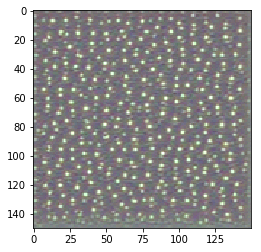

In [0]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

In [0]:
layer_name = 'block1_conv1' 
size = 64 
margin = 5

results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))

for i in range(8): 
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        horizontal_start = i * size + i *margin 
        horizontal_end = horizontal_start + size 
        vertical_start = j * size + j *margin 
        vertical_end = vertical_start + size 
        results[horizontal_start: horizontal_end, 
                vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20)) 
plt.imshow(results)

### 5.4.3 Visualizing heatmaps of class activation

In [0]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 6s 0us/step


In [0]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

In [0]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512): conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
